In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Load your dataset
df = pd.read_csv("./data/tweet.csv")
print(f"Number of examples is: {len(df)}")
df.head()
device = torch.device("mps")
# Map sentiment to categorical
sentiment_mapping = {"negatif": 0, "netral": 1, "positif": 2}
df['sentimen'] = df['sentimen'].map(sentiment_mapping)



Number of examples is: 1815


In [9]:
# Split the dataset
MODEL_NAME = 'indolem/indobert-base-uncased'

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization and DataLoader
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

/opt/anaconda3/envs/pr_1_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
def tokenize_data(data, max_len):
    inputs = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True
        )
        inputs.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    return torch.tensor(inputs), torch.tensor(attention_masks)

In [11]:


train_inputs, train_masks = tokenize_data(train_df['tweet'], 128)
val_inputs, val_masks = tokenize_data(val_df['tweet'], 128)

train_labels = torch.tensor(train_df['sentimen'].values)
val_labels = torch.tensor(val_df['sentimen'].values)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

# Define model
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.to(device)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/envs/pr_1_venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:

# Training the model (example)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
epochs = 4

In [13]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_correct = 0
    for step, batch in enumerate(train_loader):
        inputs, attention_mask, labels = batch
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()
        train_correct += (preds == labels).cpu().numpy().sum()
    
    avg_train_loss = total_loss / len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)
    
    val_correct = 0
    val_labels_list = []
    val_preds_list = []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs, attention_mask, labels = batch
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            val_predicted = outputs.logits.argmax(dim=1)
            val_correct += (val_predicted == labels).type(torch.float).sum().item()
            val_labels_list.extend(labels.cpu().numpy())
            val_preds_list.extend(val_predicted.cpu().numpy())
    
    val_acc = val_correct / len(val_loader.dataset)
    
    print(f'epoch {epoch + 1}: Avg Loss {avg_train_loss:.4f}, Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}')


epoch 1: Avg Loss 0.9617, Train Acc 0.5317, Val Acc 0.6088
epoch 2: Avg Loss 0.7793, Train Acc 0.6598, Val Acc 0.6088
epoch 3: Avg Loss 0.6723, Train Acc 0.7149, Val Acc 0.6584
epoch 4: Avg Loss 0.4713, Train Acc 0.8264, Val Acc 0.6501


In [14]:
# Metrics calculation
precision, recall, f1, _ = precision_recall_fscore_support(val_labels_list, val_preds_list, average='weighted')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

Precision: 0.6491, Recall: 0.6501, F1-score: 0.6495


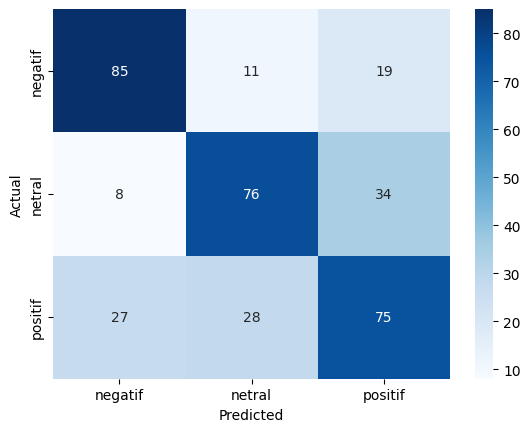

In [15]:
# Confusion matrix
cm = confusion_matrix(val_labels_list, val_preds_list)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_mapping.keys(), yticklabels=sentiment_mapping.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()